## **Introduction to Image Processing, Computer Vision and Deep Learning**
- Project-1
- 2023/11/06

### Table of Contents：
1. **Image Processing**	 
    - 1.1 Color Separation 
    - 1.2 Color Transformation
    - 1.3 Color Extraction
2. **Image Smoothing**
    - 2.1 Gaussian blur
    - 2.2 Bilateral filter 
    - 2.3 Median filter 
3. **Edge Detection**
    - 3.1 Sobel X 
    - 3.2 Sobel Y 
    - 3.3 Combination and Threshold
    - 3.4 Gradient Angle
4. **Transforms**
    - 4.1 Rotation
    - 4.2 Scaling
    - 4.3 Translate

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  2 19:41:47 2023
@author: Mr.Jiang
"""
import cv2
import numpy as np
from numpy import zeros, dot, exp, mgrid, pi, ravel, uint8, square
import matplotlib.pyplot as plt
# from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QPlainTextEdit, QFileDialog, QLineEdit
# from PyQt5.QtGui import QIcon
from itertools import product
import math
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import vgg19_bn
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from IPython.display import display, Image
from PIL import Image as PILImage
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


In [2]:
# run on Kaggle
import os

# Kaggle input / working
os.listdir("/kaggle/working/") # reset
print(os.listdir('/kaggle/input/cifar10-python/'))


['cifar-10-python.tar.gz', 'cifar-10-batches-py']


### **cv2.imencode() 和 IPython.display.Image 將圖片嵌入 Notebook 輸出**

- **ret, buffer = cv2.imencode('.jpg', image)**
    - **cv2.imencode() 將圖片壓縮 encode**
    - '.jpg' → 指定格式
    - ret → 轉換是否成功（True 或 False）
    - buffer → 轉換後的二進位數據

- **display(Image(data=buffer.tobytes()))**
    - **buffer.tobytes() 轉換為二進位數據**
    - Image(data=...) 讓 Jupyter Notebook 直接顯示圖片，不需存成檔案


### **RGB（紅、綠、藍）vs. HSV（色相、飽和度、明度）**

- RGB 基於**加法混色**（Additive Color Model），主要用於光學顯示（如電腦螢幕、電視、投影機等）。  
每個顏色都是由紅（Red）、綠（Green）、藍（Blue）三個基色混合而成，不同的組合形成不同的顏色。
    - **範圍**：每個顏色通道通常為 0-255（8-bit），或 0-1（Normalization）
    - **(0, 0, 0)**：黑色（無光）
    - **(255, 255, 255)**：白色（全光）
    - **(255, 0, 0)**：純紅
    - **(0, 255, 0)**：純綠
    - **(0, 0, 255)**：純藍


- HSV 是**基於人眼的色彩感知模型**，將顏色分成三個維度：
    - **H（Hue，色相）**：代表顏色的類型，如紅、藍、黃，取值範圍為 **0° - 360°**
    - **S（Saturation，飽和度）**：表示顏色的純度，範圍 **0-1** 或 **0-100%**；0% 是灰色，100% 最鮮豔
    - **V（Value，明度）**：控制亮度，範圍 **0-1** 或 **0-100%**；0% 是黑色，100% 最亮
    - HSV 更符合人類對顏色的直覺感知

**GB vs. HSV 差異**

| 特色        | RGB | HSV |
|------------|----|----|
| **用途** | 電腦顯示、影像處理 | 影像編輯、顏色篩選、色彩調整 |
| **顏色表示** | 透過 R/G/B 三色混合 | 透過色相（H）+飽和度（S）+亮度（V）描述 |
| **亮度控制** | 需要同時調整 R、G、B | 直接調整 V（明度） |
| **飽和度控制** | 需要對 R、G、B 做數學計算 | 直接調整 S（飽和度） |
| **顏色調整直覺性** | 不直觀，需調整三個通道 | 直觀，只需調整 H 來改變顏色 |
| **轉換計算** | 直接在 3D 色彩空間運算 | 需要極坐標轉換（較複雜） |


- **適合使用 RGB 的情境**
    - **電腦顯示技術**：因為螢幕是透過 R、G、B 三色混合來呈現顏色。
    - **機器學習與深度學習**：圖像資料通常以 RGB 儲存，許多神經網路使用 RGB 格式作為輸入。
    - **低階影像處理**：例如直接操作像素值（如 OpenCV 讀取影像時通常使用 BGR 格式）。

- **適合使用 HSV 的情境**
    - **影像處理與編輯**：HSV 允許獨立調整顏色（H）、飽和度（S）和亮度（V），更容易進行色彩篩選或變更。
    - **顏色篩選**：HSV 色彩模型對於區分不同顏色更加有效，如 OpenCV 影像處理中的顏色偵測常用 HSV。
    - **顏色校正**：可獨立控制亮度（V）而不影響顏色（H），這在調整照片曝光度時非常有用。


1.1 Buttom clicked
b.shape: (452, 640)
g.shape: (452, 640)
r.shape: (452, 640)

Displayed: Origin, RGB.jpg


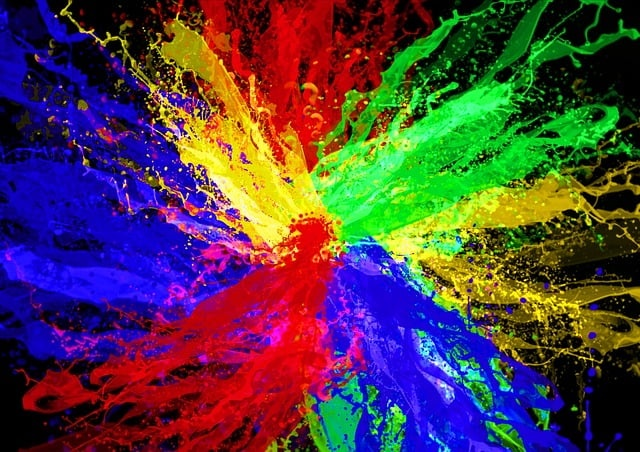


Displayed: B_channel


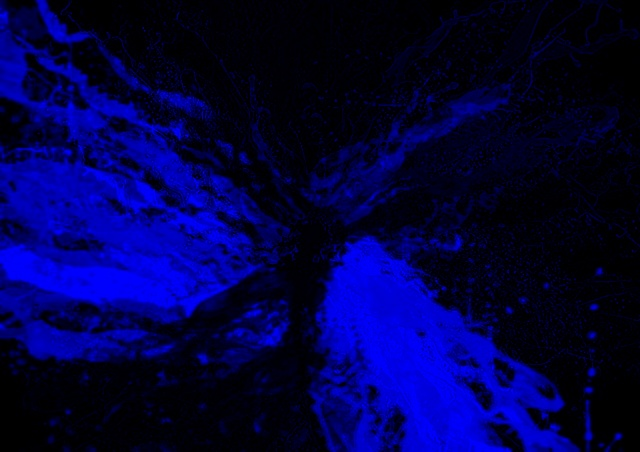


Displayed: G_channel


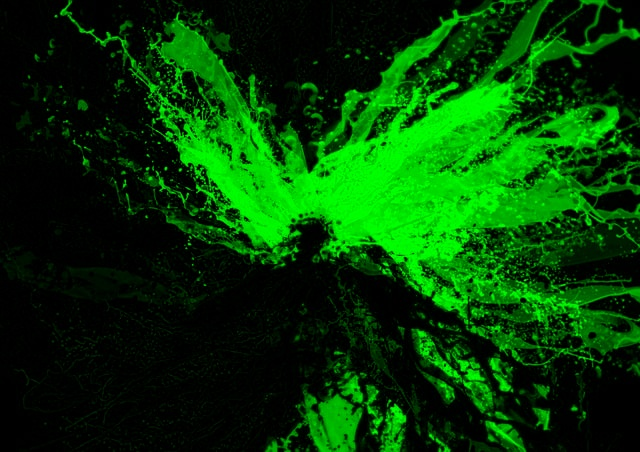


Displayed: R_channel


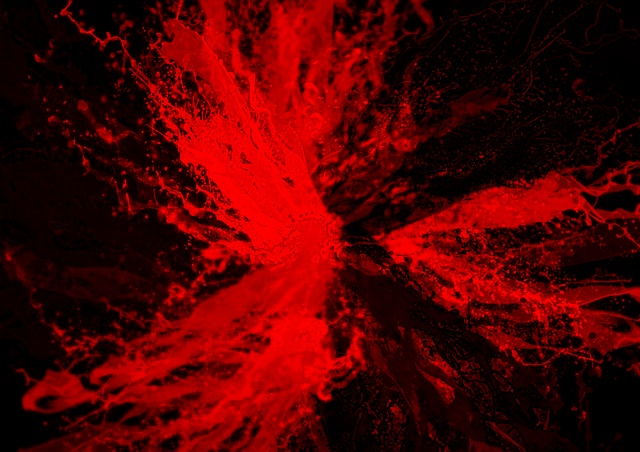

In [72]:
# 1.1 Color Separation---------------------------------------------------

class Q11():
    def Color_Separation(self):
        print("1.1 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")

        # cv2.split(image) get B, G, R
        if image is not None:
            b, g, r = cv2.split(image)

            # (452, 640)
            print(f"b.shape: {b.shape}\n" +
                  f"g.shape: {g.shape}\n" +
                  f"r.shape: {r.shape}")

            # cv2.merge(b,g,r)
            # np.zeros_like() 填充不需要的 channel
            rgb_b = cv2.merge([b, np.zeros_like(g), np.zeros_like(r)])
            rgb_g = cv2.merge([np.zeros_like(b), g, np.zeros_like(r)])
            rgb_r = cv2.merge([np.zeros_like(b), np.zeros_like(g), r])

            # display R, G, B channel
            cv2.imwrite("RGB.jpg", image)
            print("\nDisplayed: Origin, RGB.jpg")
            display(Image(filename="RGB.jpg"))

            cv2.imwrite("RGB_b.jpg", rgb_b)
            print("\nDisplayed: B_channel")
            display(Image(filename="RGB_b.jpg"))

            cv2.imwrite("RGB_g.jpg", rgb_g)
            print("\nDisplayed: G_channel")
            display(Image(filename="RGB_g.jpg"))

            cv2.imwrite("RGB_r.jpg", rgb_r)
            print("\nDisplayed: R_channel")
            display(Image(filename="RGB_r.jpg"))

        else:
            print("請先選擇圖片")

q11 = Q11()
q11.Color_Separation()


1.2 Buttom clicked

Displayed: I1, Standard Gray


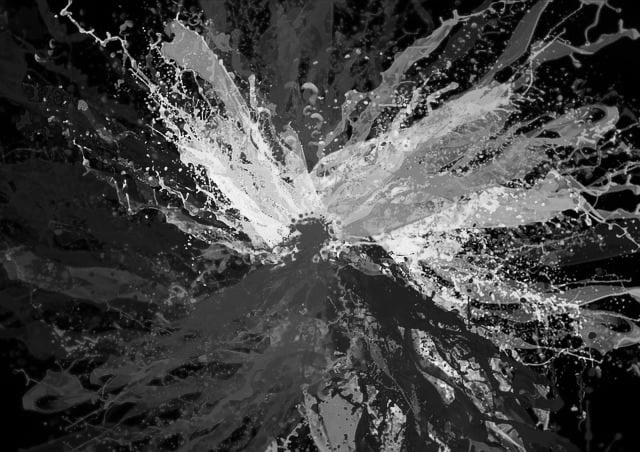


Displayed: I2, Weighted Gray


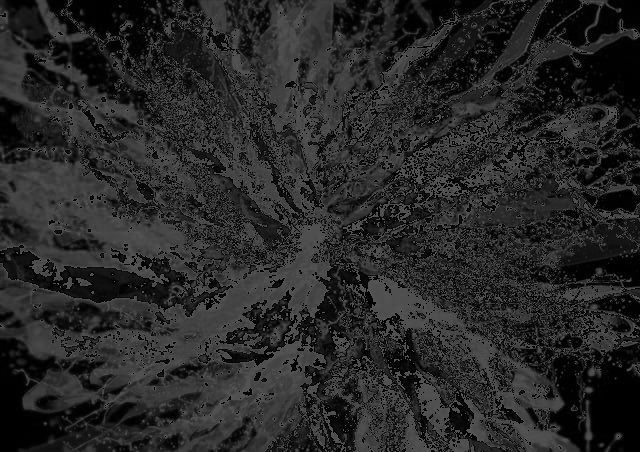

In [23]:
# 1.2 Color Transformation-----------------------------------------------

class Q12():
    def Color_Transformation(self):
        print("1.2 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")
        if image is not None:
            b, g, r = cv2.split(image)

            # "rgb.jpg" convert to gray -> I1
            # Standard Gray = 0.299 * R + 0.587 * G + 0.114 * B
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            i2 = r + g + b

            # set channel weight
            weight = 1/3.0 # float

            weighted_gray_image = np.zeros_like(i2, dtype=np.float32) # set shape
            weighted_gray_image = i2 * weight

            # float32 -> uint8 for image display or store
            weighted_gray_image = weighted_gray_image.astype(np.uint8) # np.uint8（0-255）

            # display
            cv2.imwrite("Gray_image.jpg", gray_image)
            print("\nDisplayed: I1, Standard Gray")
            display(Image(filename="Gray_image.jpg"))

            cv2.imwrite("Weighted_gray_image.jpg", weighted_gray_image)
            print("\nDisplayed: I2, Weighted Gray")
            display(Image(filename="Weighted_gray_image.jpg"))

        else:
            print("請先選擇圖片")

q12 = Q12()
q12.Color_Transformation()


1.3 Buttom clicked

Displayed: I1


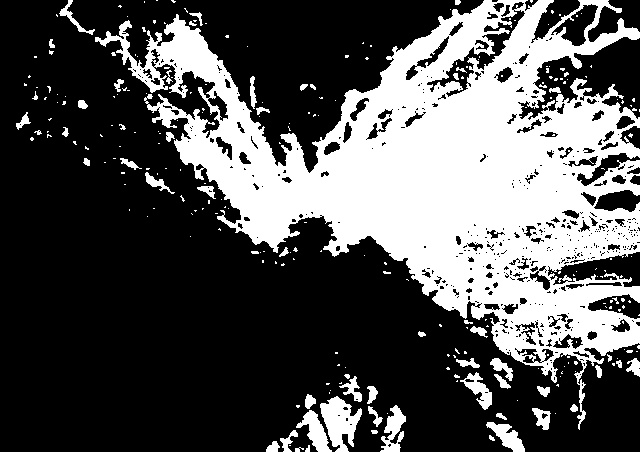


Displayed: I2


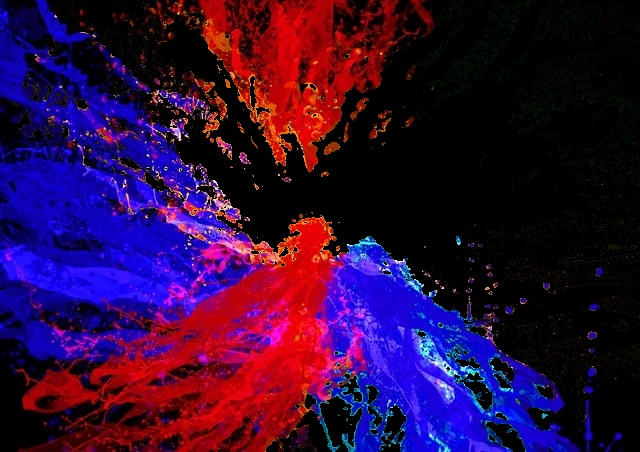

In [24]:
# 1.3 Color Extraction---------------------------------------------------

class Q13():
    def Color_Extraction(self):
        print("1.3 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")

        if image is not None:
            # convert RGB to HSV（Hue, Saturation, Value）
            hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # define 黃綠色區域的下限和上限
            '''
            Hue = 16~85 → 涵蓋黃綠色
            Saturation = 27~255 → 避免過於灰色或不飽和的區域被選到。
            Value = 25~255 → 允許不同亮度的顏色。
            '''
            lower_bound = np.array([16, 27, 25])
            upper_bound = np.array([85, 255, 255])

            # cv2.inRange() 產生遮罩，將範圍內的黃綠色設為白色（255），其他顏色為黑色（0）
            i1 = cv2.inRange(hsv_img, lower_bound, upper_bound)

            # inverse mask -> 黃綠色設為黑色（0），其他顏色為白色（255）
            yellow_green_mask = cv2.bitwise_not(i1)

            # inverse mask apply to image
            i2 = cv2.bitwise_and(image, image, mask=yellow_green_mask)

            # display
            cv2.imwrite("I1.jpg", i1)
            print("\nDisplayed: I1")
            display(Image(filename="I1.jpg"))

            cv2.imwrite("I2.jpg", i2)
            print("\nDisplayed: I2")
            display(Image(filename="I2.jpg"))


        else:
            print("請先選擇圖片")

q13 = Q13()
q13.Color_Extraction()


### **Gaussian Blur vs. Bilateral Filter vs. Median Filter**


| **Filter**           | **主要作用**                                      | **適用場景** |
|--------------------|--------------------------------|--------------|
| **Gaussian Blur**   | 平滑影像，減少高頻雜訊（去除細節）              | 一般模糊處理、降噪、邊緣檢測前的預處理 |
| **Bilateral Filter** | 平滑影像的同時保留邊緣細節                      | 影像去雜訊但不希望模糊邊緣，例如人臉美化 |
| **Median Filter**   | 透過中值運算去除椒鹽雜訊（Salt & Pepper Noise） | 處理含椒鹽雜訊的影像，如掃描文件修復 |


1. **(1) Gaussian Blur**
- 使用高斯函數對影像進行平滑處理，使像素值根據周圍像素的加權平均來更新，並且權重遵循**高斯分佈（Gaussian Distribution)**。

    - 能夠平滑影像，去除高頻雜訊
    - **會模糊邊緣，影像細節可能喪失**
    - 適用於**影像降噪**、**邊緣檢測前處理**

- 適用：
    - 邊緣檢測前的預處理（如：Canny Edge Detection）
    - 影像縮小時的平滑處理
    - 處理低雜訊影像的模糊效果

2. **(2) Bilateral Filter（雙邊濾波）**
- 雙邊濾波不僅考慮空間鄰近性，還考慮像素的**色彩相似度**，透過這種方式，可以**平滑影像的同時保留邊緣細節**。

    - **可平滑影像並保留邊緣**
    - **比 Gaussian Blur 更複雜，計算成本較高**
    - **適合人臉美化、噪點去除，但保留紋理**

- 適用：
    - **人臉修飾**（去除細小雜訊，但保留輪廓）
    - **保留邊緣的降噪**（如 MRI 醫學影像）
    - **動畫影像降噪**（讓畫面更乾淨但不模糊輪廓）

3. **(3) Median Filter（中值濾波）**
 - 中值濾波主要用於去除 **椒鹽雜訊（Salt & Pepper Noise）**，即影像中出現的隨機黑點或白點，它不是透過平均像素值，而是取周圍像素的**中值**來替換當前像素。

    - **專門用於消除椒鹽雜訊**
    - **不會模糊邊緣**
    - **對於高斯雜訊（Gaussian Noise）效果較差**

- 計算方式：
    1. 取出一個 **k × k** 區域內的所有像素值
    2. 對這些像素排序
    3. 取**中位數**來替換當前像素值

- 適用：
    - **掃描文件修復**
    - **老舊照片降噪**
    - **醫學影像處理（如 CT 掃描去雜訊）**


| **特性**            | **Gaussian Blur** | **Bilateral Filter** | **Median Filter** |
|------------------|-----------------|------------------|----------------|
| **降噪能力**      |  **⭐⭐⭐**        | **⭐⭐⭐⭐**             | **⭐⭐⭐⭐**（對椒鹽雜訊效果最佳） |
| **邊緣保留能力**  | **❌**（模糊邊緣）  | **✔️**（能保留邊緣） | **✔️**（不模糊邊緣） |
| **適用雜訊類型**  | **高斯雜訊**    | **一般影像雜訊** | **椒鹽雜訊** |
| **計算成本**      | **⭐⭐**（較快）     | **⭐⭐⭐⭐**（較慢）    | **⭐⭐⭐** （適中） |
| **應用場景**      | 邊緣檢測前處理 | 影像降噪但保留細節 | 影像含椒鹽雜訊 |


2.1 Button clicked

Displayed: Gaussian Blur with kernel size (3, 3)


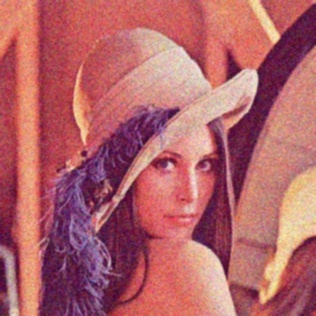


Displayed: Gaussian Blur with kernel size (5, 5)


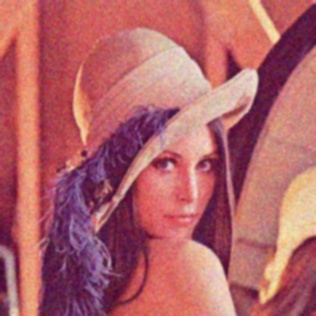


Displayed: Gaussian Blur with kernel size (7, 7)


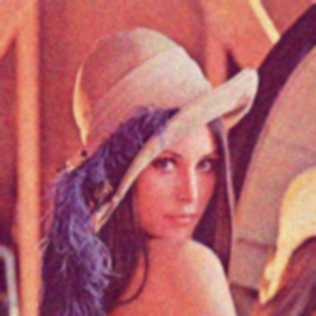


Displayed: Gaussian Blur with kernel size (9, 9)


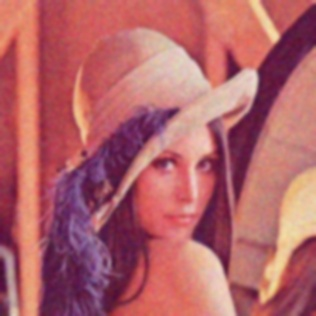


Displayed: Gaussian Blur with kernel size (11, 11)


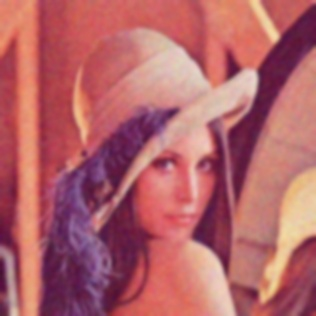

In [29]:
# 2.1 Gaussian Blur------------------------------------------------------

class Q21():
    def Gaussian_Blur(self):
        print("2.1 Button clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:

            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [(3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,(3,3))

                # apply to Gaussian Blur
                blurred_image = cv2.GaussianBlur(image, kernel_size, sigmaX=0, sigmaY=0) # sigmaX、sigmaY 為高斯標準差，0 代表讓 OpenCV 自動計算最合適的標準差

                # display
                ret, buffer = cv2.imencode('.jpg', blurred_image)
                print(f"\nDisplayed: Gaussian Blur with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q21 = Q21()
q21.Gaussian_Blur()


2.2 Buttom clicked

Displayed: Bilateral Filter with kernel size 3


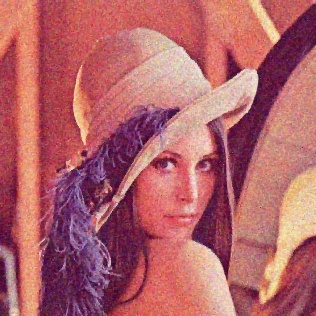


Displayed: Bilateral Filter with kernel size 5


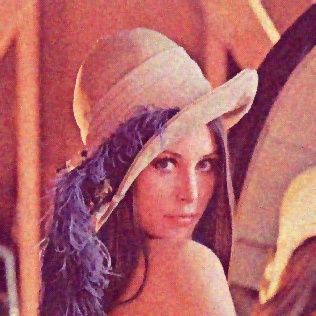


Displayed: Bilateral Filter with kernel size 7


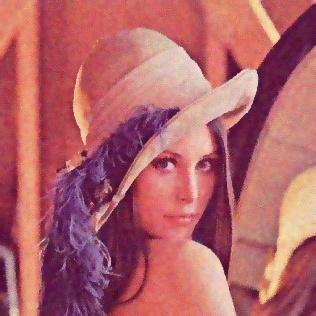


Displayed: Bilateral Filter with kernel size 9


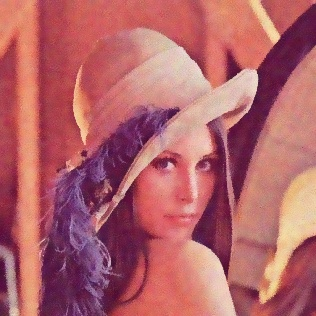


Displayed: Bilateral Filter with kernel size 11


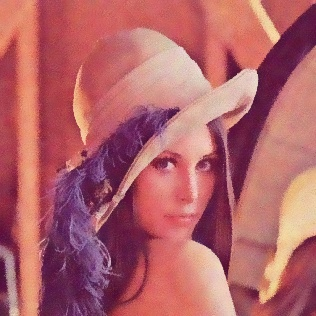

In [31]:
# 2.2 Bilateral Filter---------------------------------------------------

class Q22():
    def Bilateral_Filter(self):
        print("2.2 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:

            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [3, 5, 7, 9, 11]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,3)

                # apply to Bilateral Filter
                filtered_image = cv2.bilateralFilter(image, kernel_size, sigmaColor=90, sigmaSpace=90)

                # display
                ret, buffer = cv2.imencode('.jpg', filtered_image)
                print(f"\nDisplayed: Bilateral Filter with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q22 = Q22()
q22.Bilateral_Filter()


2.3 Buttom clicked

Displayed: Median Filter with kernel size 3


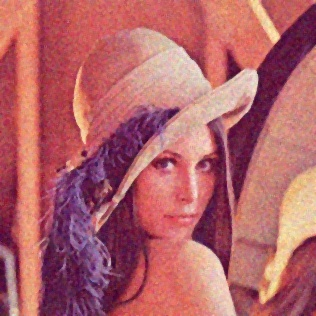


Displayed: Median Filter with kernel size 5


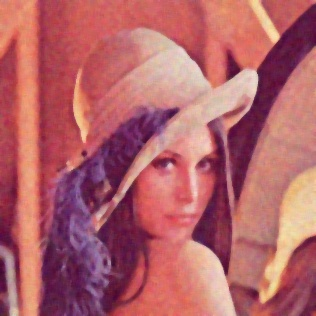


Displayed: Median Filter with kernel size 7


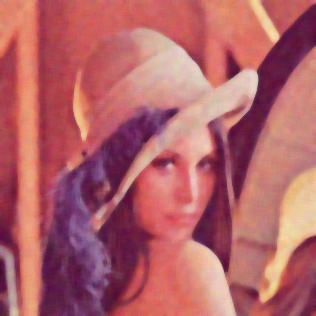


Displayed: Median Filter with kernel size 9


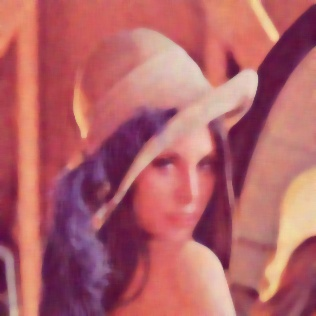


Displayed: Median Filter with kernel size 11


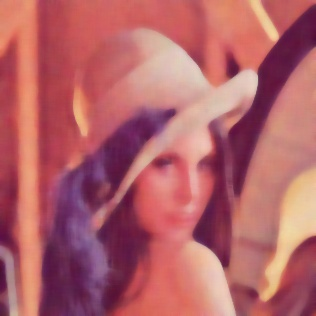

In [32]:
# 2.3 Median Filter------------------------------------------------------

class Q23():
    def Median_Filter(self):
        print("2.3 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:

            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [3, 5, 7, 9, 11]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,3)

                # apply to Median Filter
                filtered_image = cv2.medianBlur(image, kernel_size)

                # display
                ret, buffer = cv2.imencode('.jpg', filtered_image)
                print(f"\nDisplayed: Median Filter with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q23 = Q23()
q23.Median_Filter()


### **Sobel 邊緣檢測 (Sobel Edge Detection)**
- **Sobel 運算子（Sobel Operator）** 是一種 Edge Detection 技術，運算的主要目的是計算影像的梯度，也就是**像素亮度變化的速率**，用於強調影像中的邊緣特徵，特別是梯度變化較大的區域，如：物體邊界，是一個一階微分的 filter，主要計算影像在 **x 軸與 y 軸方向的梯度變化**，進而找出邊緣。

- Sobel 運算子屬於**微分運算子（Derivative Operator）**，其原理是使用卷積運算（Convolution）來計算影像的梯度。
- 透過兩個 **3×3 的卷積核（Kernel）** 來分別計算影像在水平方向與垂直方向的梯度：

1. **水平方向（X 軸）梯度卷積核**用於偵測**垂直邊緣**（Vertical Edges）。
\
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}



2. **垂直方向（Y 軸）梯度卷積核**用於偵測**水平邊緣**（Horizontal Edges）。
\
\begin{bmatrix}
-1 & -2 & -1 \\
0  &  0 &  0 \\
1  &  2 &  1
\end{bmatrix}

- **優點**：
    - 能夠同時檢測 **水平方向** 和 **垂直方向** 的邊緣。
    - 相較於單純的微分運算（如 Roberts 運算子），Sobel 具有**平滑效果**，能夠減少噪聲影響。
    - 計算量低，適合即時處理（如影像偵測應用）。

- **缺點**：
    - 只能偵測 **一階梯度變化**，無法準確找到較微弱的邊緣。
    - 對於含有較多雜訊的影像，檢測效果不佳，需要搭配**高斯模糊（Gaussian Blur）**來去雜訊。

- **主要用於**：
    - **影像邊緣檢測**
    - **物件輪廓強化**
    - **影像特徵提取**（如：手寫字辨識）
    - **工業檢測**（如：瑕疵檢測）


3.1 Buttom clicked, wait a minute

Displayed: Origin


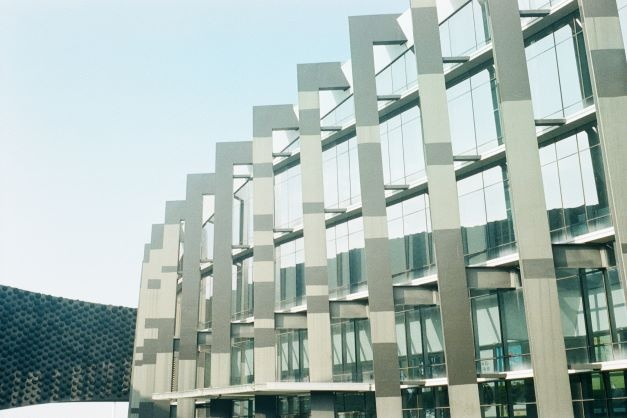


Displayed: Sobel x


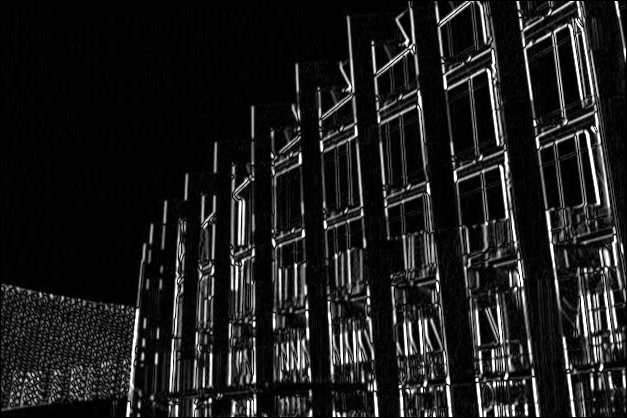

In [6]:
# 3.1 Sobel x -----------------------------------------------------------

class Q31():
    def Sobel_X(self): # 邊緣就是影像中，像素值突然改變的地方
        print("3.1 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

            # sobel_X
            container = np.copy(blurred_image) # container = np.copy() set copy，避免直接操作原圖片
            size = container.shape
            row = size[0]
            col = size[1]

            # 從左上角到右下角的順序進行
            sobel = np.zeros((row, col), dtype = np.int16) # 儲存 Sobel 運算結果
            for i in range(row):
                for j in range(col): # row - 1 跟 col - 1 分別為最底下那列跟最右邊那行
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel[i][j] = 0 # 這些像素由於缺乏完整的相鄰像素，因此在進行卷積運算時，需要特別處理；梯度為 0，代表邊緣的「變化率」是 0
                    else:
                        # 使用 3x3 Sobel 核心矩陣 ([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]) 對當前像素及其周圍像素進行加權求和
                        sobel[i][j] = (-2.0) * container[i][j - 1] + 0.0 * container[i][j] + 2.0 * container[i][j + 1] + (-1.0) * container[i - 1][j - 1] + 0.0 * container[i - 1][j] + 1.0 * container[i - 1][j + 1] + (-1.0) * container[i + 1][j - 1] + 0.0 * container[i + 1][j] + 1.0 * container[i + 1][j + 1]

            # 將運算結果取絕對值，並 dtype -> uint8
            sobel = cv2.convertScaleAbs(sobel)

            # display
            ret, buffer = cv2.imencode('.jpg', image)
            print("\nDisplayed: Origin")
            display(Image(data=buffer.tobytes()))

            ret, buffer = cv2.imencode('.jpg', sobel)
            print(f"\nDisplayed: Sobel x")
            display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q31 = Q31()
q31.Sobel_X()


3.2 Buttom clicked, wait a minute

Displayed: Origin


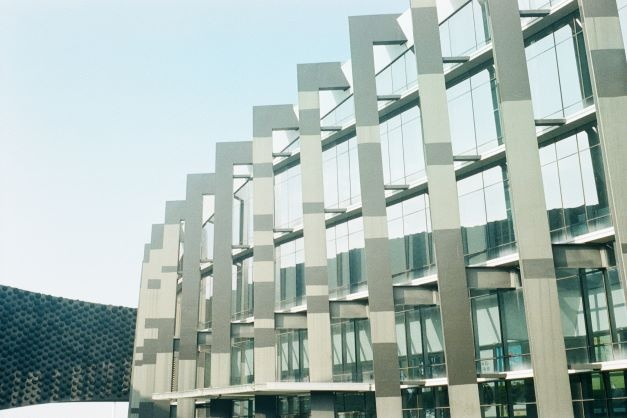


Displayed: Sobel y


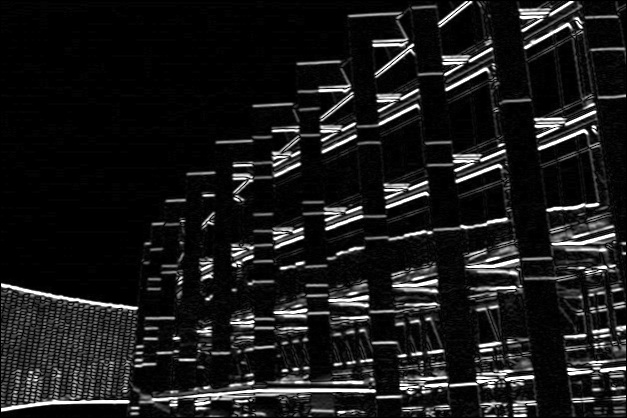

In [4]:
# 3.2 Sobel y -----------------------------------------------------------

class Q32():
    def Sobel_Y(self):
        print("3.2 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

            # sobel_Y
            container = np.copy(blurred_image) # container size = blurred_image
            size = container.shape
            row = size[0]
            col = size[1]

            # for storing operation result
            sobel = np.zeros((row, col), dtype = np.int16)

            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel[i][j] = 0  # 同樣在圖片四周都將 weight = 0
                    else:
                        # 非四周做運算 ([-1, -2, -1], [0, 0, 0], [1, 2, 1])
                        sobel[i][j] = (2.0) * container[i + 1][j] + 0.0 * container[i][j] + (-2.0) * container[i - 1][j] + (1.0) * container[i + 1][j - 1] + 0.0 * container[i][j - 1] + (-1.0) * container[i - 1][j - 1] + (1.0) * container[i + 1][j + 1] + 0.0 * container[i][j + 1] + (-1.0) * container[i - 1][j + 1]

            # 將運算結果取絕對值，並 dtype -> uint8
            sobel = cv2.convertScaleAbs(sobel)

            # display
            ret, buffer = cv2.imencode('.jpg', image)
            print("\nDisplayed: Origin")
            display(Image(data=buffer.tobytes()))

            ret, buffer = cv2.imencode('.jpg', sobel)
            print(f"\nDisplayed: Sobel y")
            display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q32 = Q32()
q32.Sobel_Y()


3.3 Buttom clicked, wait a minute

Displayed: Combination


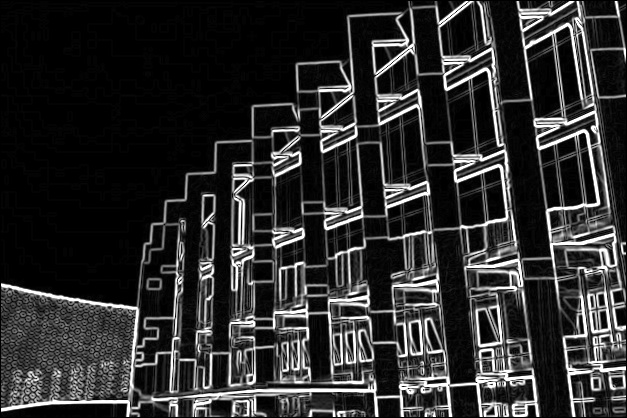


Displayed: Threshold Result


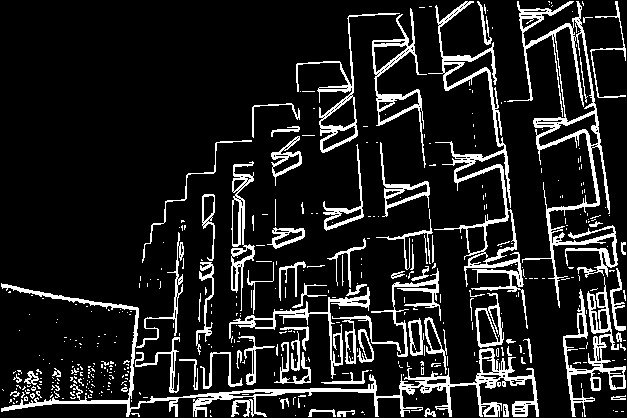

In [29]:
# 3.3 Combination and Threshold------------------------------------------

class Q33():
    def Combination_and_Threshold(self):
        print("3.3 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

            container1 = np.copy(blurred_image) # for sobel X
            container2 = np.copy(blurred_image) # for sobel Y
            size = container1.shape
            row = size[0]
            col = size[1]

            # for storing operation result
            sobel_x = np.zeros((row, col), dtype = np.int16)
            sobel_y = np.zeros((row, col), dtype = np.int16)
            combine_xy = np.zeros((row, col), dtype = np.uint16)

            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel_x[i][j] = 0
                    else:
                        # ([-1, 0, 1], [-2, 0, 2], [-1, 0, 1])
                        sobel_x[i][j] = (-2.0) * container1[i][j - 1] + 0.0 * container1[i][j] + 2.0 * container1[i][j + 1] + (-1.0) * container1[i - 1][j - 1] + 0.0 * container1[i - 1][j] + 1.0 * container1[i - 1][j + 1] + (-1.0) * container1[i + 1][j - 1] + 0.0 * container1[i + 1][j] + 1.0 * container1[i + 1][j + 1]


            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel_y[i][j] = 0
                    else:
                        # ([-1, -2, -1], [0, 0, 0], [1, 2, 1])
                        sobel_y[i][j] = (2.0) * container2[i + 1][j] + 0.0 * container2[i][j] + (-2.0) * container2[i - 1][j] + (1.0) * container2[i + 1][j - 1] + 0.0 * container2[i][j - 1] + (-1.0) * container2[i - 1][j - 1] + (1.0) * container2[i + 1][j + 1] + 0.0 * container2[i][j + 1] + (-1.0) * container2[i - 1][j + 1]

            sobelx = sobel_x
            sobely = sobel_y

            # == cv2.magnitude()
            for i in range(row):
                for j in range(col):
                    combine_xy[i][j] = min(255, np.sqrt(sobelx[i][j] ** 2 + sobely[i][j] ** 2)) # Normalize combination

            # combine_xy result
            combined_image = cv2.convertScaleAbs(combine_xy)

            # threshold_result
            threshold = 128
            threshold_result = np.zeros_like(combined_image)
            threshold_result[combined_image < threshold] = 0
            threshold_result[combined_image >= threshold] = 255

            # display
            ret, buffer = cv2.imencode('.jpg', combined_image)
            print("\nDisplayed: Combination")
            display(Image(data=buffer.tobytes()))

            ret, buffer = cv2.imencode('.jpg', threshold_result)
            print("\nDisplayed: Threshold Result")
            display(Image(data=buffer.tobytes()))

        else:
            self.labelL1.setText("請先選擇圖片")

q33 = Q33()
q33.Combination_and_Threshold()


3.4 Buttom clicked, wait a minute
Gradient Angle Min: 0.0, Max: 359.8258492307934

Displayed: Angle Range 120~180


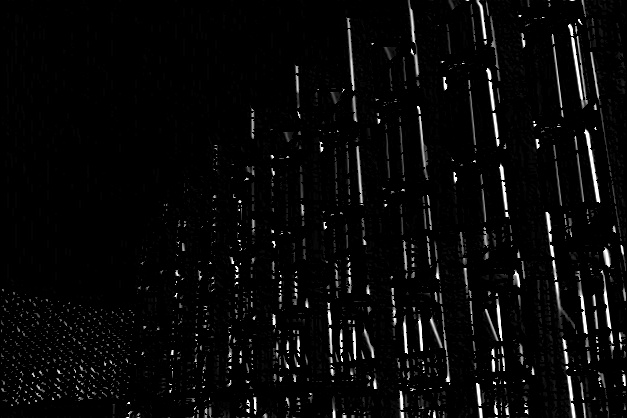


Displayed: Angle Range 210~330


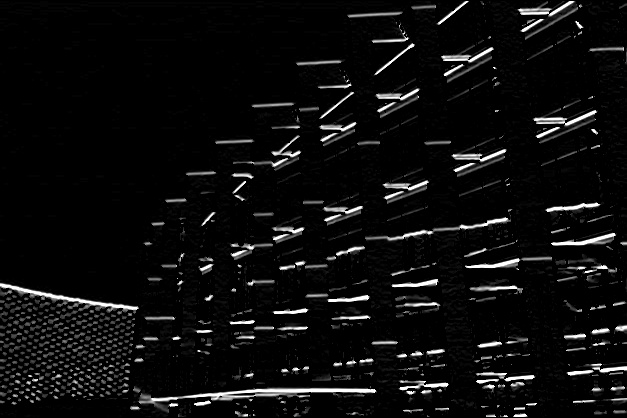

In [30]:
# 3.4 Gradient Angle ----------------------------------------------------

class Q34():
    def Gradient_Angle(self):
        print("3.4 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

        # cv.Sobel() 支援 CV_64F float 避免數值溢位，保留負數，以確保正確計算梯度
        sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
        combine_xy = cv2.magnitude(sobelx, sobely)
        combined_image = cv2.convertScaleAbs(combine_xy)

        # np.arctan 計算梯度角度
        gradient_angle = np.arctan2(sobely, sobelx) * 180 / np.pi
        gradient_angle[gradient_angle < 0] += 360

        # inspect angle
        print(f"Gradient Angle Min: {gradient_angle.min()}, Max: {gradient_angle.max()}")

        mask1 = ((gradient_angle >= 120) & (gradient_angle <= 180)).astype(np.uint8) * 255
        mask2 = ((gradient_angle >= 210) & (gradient_angle <= 330)).astype(np.uint8) * 255

        # bitwise_and -> put on mask
        result1 = cv2.bitwise_and(combined_image, combined_image, mask=mask1)
        result2 = cv2.bitwise_and(combined_image, combined_image, mask=mask2)

        # display
        ret, buffer = cv2.imencode('.jpg', result1)
        print("\nDisplayed: Angle Range 120~180")
        display(Image(data=buffer.tobytes()))

        ret, buffer = cv2.imencode('.jpg', result2)
        print("\nDisplayed: Angle Range 210~330")
        display(Image(data=buffer.tobytes()))

q34 = Q34()
q34.Gradient_Angle()


The hight(row.shape) of image: 1080
The width(col.shape) of image: 1920

Displayed: Origine


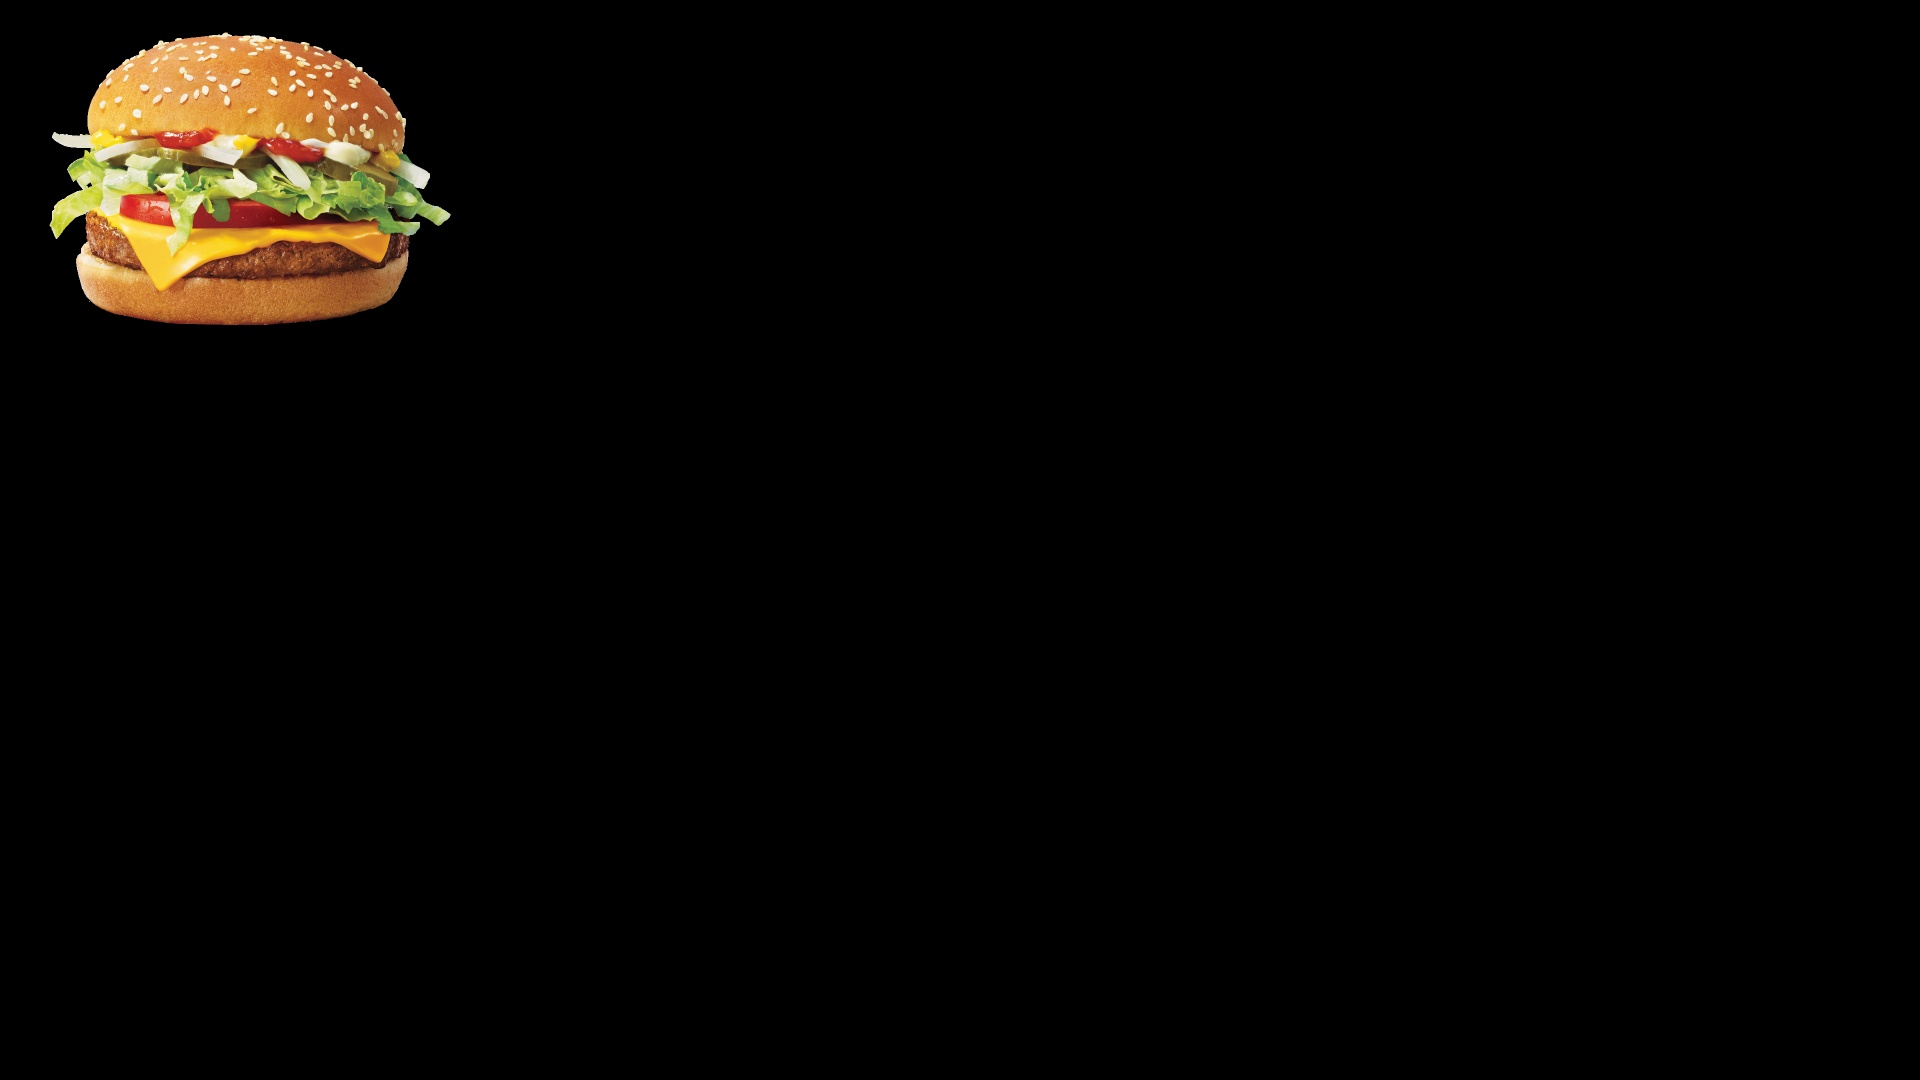


Displayed: Transformed image


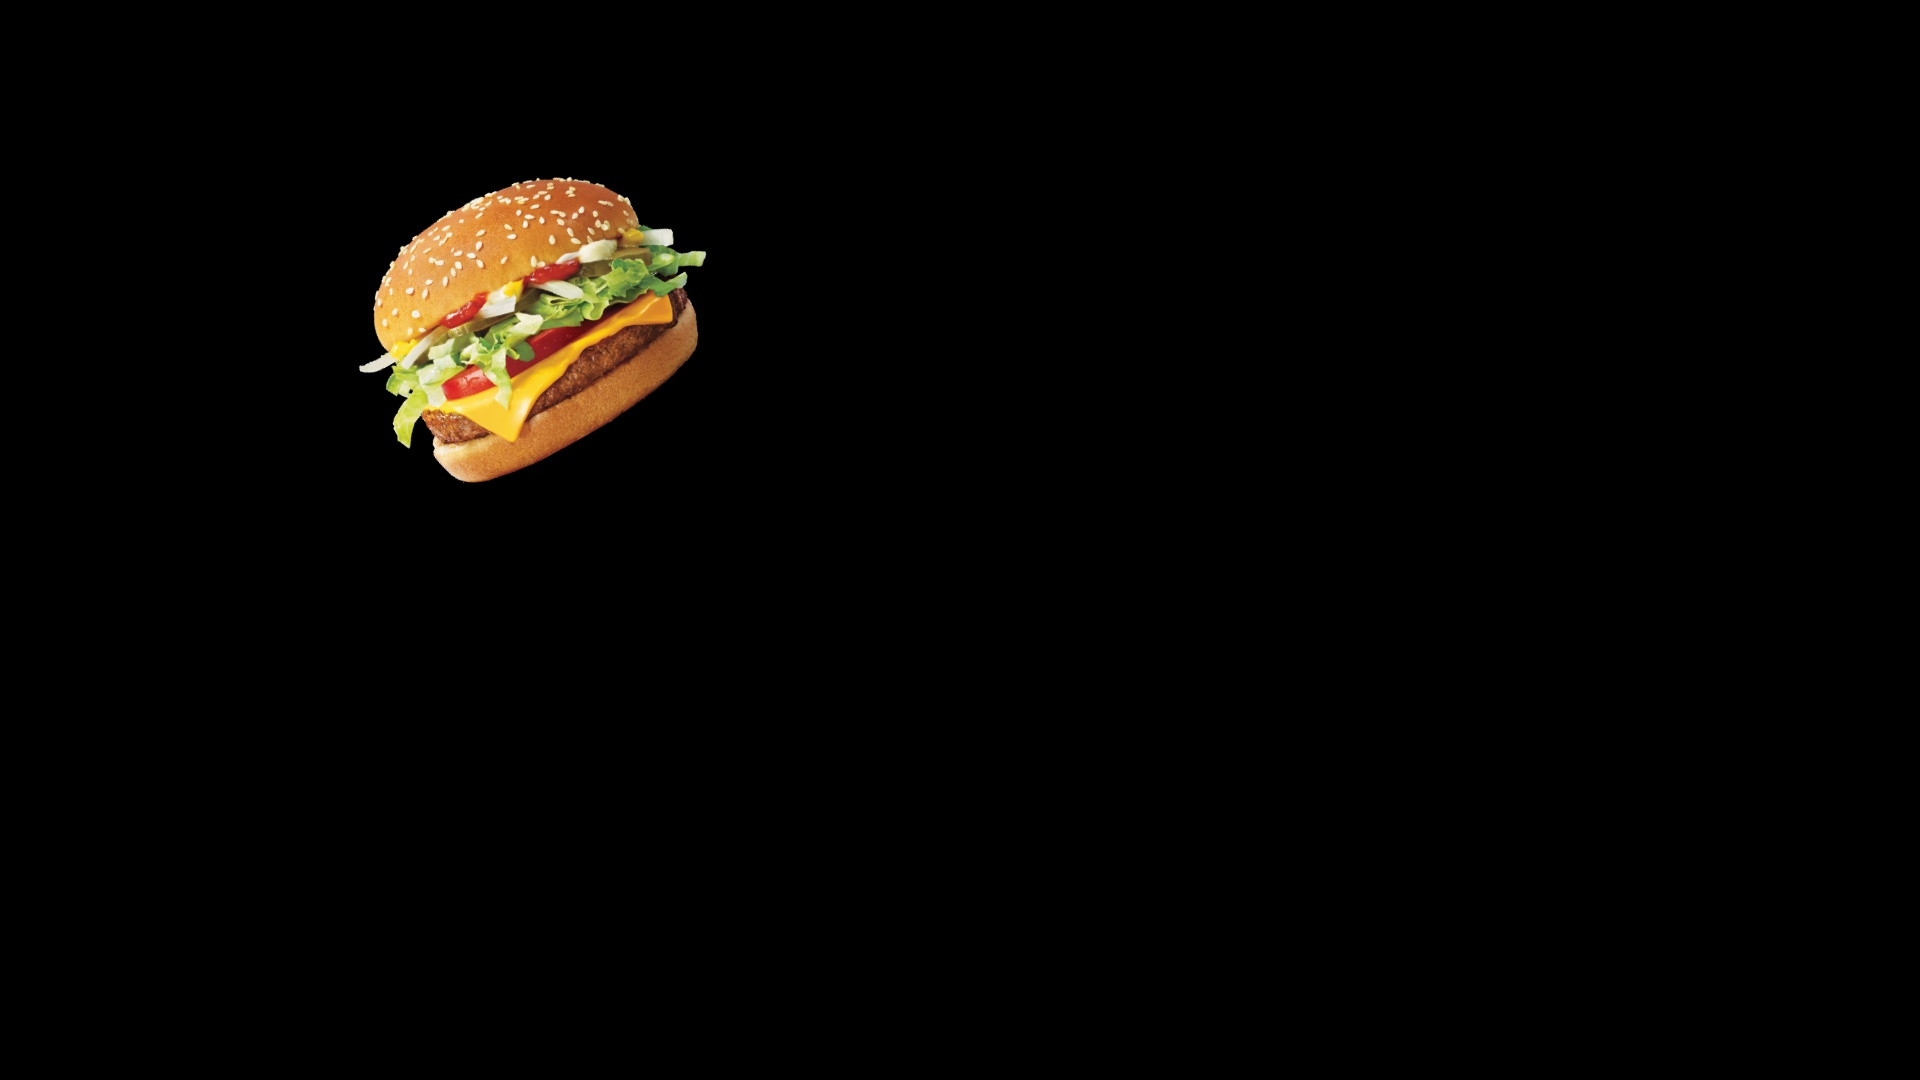

In [2]:
# 4. Transforms----------------------------------------------------------
'''
(1) Angle = 30 (positive degree-> counter-clockwise)
(2) Scale = 0.9
(3) Translation with:
X_new = X_old + 535 pixels = 240 + 535 = 775
Y_new = Y_old + 335 pixels = 200 + 335 = 535
'''
class Q4():
    def Transforms(self, angle, scale, translation_x, translation_y):
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q4_image/burger.png")

        # image center
        (hight, width) = image.shape[:2]
        print(f"The hight(row.shape) of image: {hight}\nThe width(col.shape) of image: {width}")

        # hamburger center
        center = (240, 200) # (x,y)

        '''
        [ a, b, c ] a, b, d, e：控制旋轉、縮放和剪切等線性變換
        [ d, e, f ] c：水平方向的平移分量, f：垂直方向的平移分量
        根據 center 和 angle，會自動計算 a, b, d, e 的值
        '''
        # cv2.getRotationMatrix2D() 建立一個 2x3 的仿射變換矩陣 M
        M = cv2.getRotationMatrix2D(center, angle, scale)
        '''
        center：影像的旋轉中心點。
        angle：旋轉角度，正值表示逆時針旋轉，負值表示順時針旋轉。
        scale：縮放比例。
        '''
        # Translation
        M[0, 2] += translation_x - center[0]
        M[1, 2] += translation_y - center[1]

        # cv2.warpAffine(img, M, (width, hight)) 進行仿射變換後輸出 (width, hight)尺寸
        transformed_image = cv2.warpAffine(image, M, (width, hight))

        # display
        ret, buffer = cv2.imencode('.jpg', image)
        print("\nDisplayed: Origine")
        display(Image(data=buffer.tobytes()))

        ret, buffer = cv2.imencode('.jpg', transformed_image)
        print("\nDisplayed: Transformed image")
        display(Image(data=buffer.tobytes()))

q4 = Q4()
q4.Transforms(30, 0.9, 535, 335)
